<a href="https://colab.research.google.com/github/DharmitP/weather-classification/blob/master/SunNet_FeatExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image, ImageOps
from itertools import product

In [0]:
torch.manual_seed(0)

#resize and black pad images to 224x224 with no distortion
def cleaner(file):
    #resize image while keeping aspect ratio (e.g. 500x375 becomes 224x168)
    x = 224
    y = 224
    image = Image.open(file).convert("RGB")
    image.thumbnail((x, y), Image.ANTIALIAS)

    #add symmetrical black padding to the smaller dimension to match the desired x and y
    deltaX = x - image.size[0]
    deltaY = y - image.size[1]
    padding = (deltaX//2, deltaY//2, deltaX-(deltaX//2), deltaY-(deltaY//2))

    return ImageOps.expand(image, padding)

#load images from Google Drive
def loadImages(folder):
    #transform to tensor and normalize
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])

    #load data from Google Drive and clean them as they load
    dataset = torchvision.datasets.ImageFolder(root=folder, loader=cleaner, transform=transform)
    
    return dataset

datadir = '/content/drive/My Drive/APS360_Project/SunnyNet/Dataset'
# dataset = torchvision.datasets.ImageFolder(datadir, loader= cleaner, transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]))
dataset = loadImages(datadir)
overfit_indices = np.concatenate((np.arange(0,10), np.arange(1500, 1510)))
train_indices = np.concatenate((np.arange(0,900), np.arange(1500, 2400)))
valid_indices = np.concatenate((np.arange(900,1200), np.arange(2400, 2700)))
test_indices = np.concatenate((np.arange(1200,1500), np.arange(2700, 3000)))

overfit_dataset = torch.utils.data.Subset(dataset, overfit_indices)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

def get_data_loader(batch_size, overfit=False):
  if overfit:
    return torch.utils.data.dataloader.DataLoader(overfit_dataset, batch_size=batch_size, shuffle=True)
  else:
    train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.dataloader.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, valid_loader, test_loader

# fig = plt.figure()
# i = 1
# for batch in train_loader:
#   image, label = batch
#   axis = fig.add_subplot(10, 1, i)
#   i += 1
#   axis.imshow(image.T.squeeze())
#   print(label)

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(train_loader))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[x.item() for x in classes])

def visualize_model(model, loader, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # print('\n')
            # print(labels)
            # print(outputs)
            # print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}\nactual: {}'.format(preds.item(), labels.item()))
                imshow(inputs.cpu().data[j])

In [0]:
def evaluate(model, loader, criterion):
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # Iterate over data.
    for inputs, labels in loader:
        outputs = model(inputs)
        # print(outputs)
        _, preds = torch.max(outputs, 1)
        # print(preds)
        # print('\n')
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        total_samples += len(inputs)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

In [0]:
def train_model(model, t, v, criterion, optimizer, num_epochs=25, overfit=False):
    tr_acc, tr_l, v_acc, v_l = [], [], [], [] 
    l = None
    if overfit:
      l = get_data_loader(4, overfit=True)
      print(len(l)) # of batches
    else:
      l = t
      print(len(l))

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Iterate over data.
        for inputs, labels in l:
            # zero the parameter gradients
            optimizer.zero_grad()
            # print(labels)
            # print(len(inputs))

            # forward
            # track history if only in train
            outputs = model(inputs)
            # print(outputs)
            _, preds = torch.max(outputs, 1)
            # print(preds)
            # print('\n')
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            total_samples += len(inputs)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        tr_l.append(epoch_loss)
        tr_acc.append(epoch_acc)
        _vloss, _vacc = evaluate(model, v, criterion)
        v_l.append(_vloss)
        v_acc.append(_vacc)

        print('TrLoss: {:.4f} TrAcc: {:.4f} | VLoss: {:.4f} VAcc: {:.4f}'.format(
              epoch_loss, epoch_acc, _vloss, _vacc))
        # torch.save(model.state_dict(), '/content/drive/My Drive/APS360_Project/SunnyNet/Model/' + str(epoch))
    
    # plotting
    plt.title("Loss Curves")
    plt.plot(tr_l, label="Train")
    plt.plot(v_l, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('/content/drive/My Drive/APS360_Project/SunnyNet/Model/' +
                str([l.batch_size, optimizer_ft.param_groups[0]['lr']]) + "loss.png")
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(tr_acc, label="Train")
    plt.plot(v_acc, label="Validation")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('/content/drive/My Drive/APS360_Project/SunnyNet/Model/' +
                str([l.batch_size, optimizer_ft.param_groups[0]['lr']]) + "acc.png")
    plt.show()
    return model

57
Epoch 0/19
----------
TrLoss: 0.6839 TrAcc: 0.5678 | VLoss: 0.6738 VAcc: 0.6000
Epoch 1/19
----------
TrLoss: 0.6537 TrAcc: 0.7100 | VLoss: 0.6375 VAcc: 0.7983
Epoch 2/19
----------
TrLoss: 0.6067 TrAcc: 0.7322 | VLoss: 0.5891 VAcc: 0.7500
Epoch 3/19
----------
TrLoss: 0.5532 TrAcc: 0.7444 | VLoss: 0.5200 VAcc: 0.8100
Epoch 4/19
----------
TrLoss: 0.5023 TrAcc: 0.7683 | VLoss: 0.5093 VAcc: 0.7433
Epoch 5/19
----------
TrLoss: 0.4679 TrAcc: 0.7800 | VLoss: 0.4248 VAcc: 0.8350
Epoch 6/19
----------
TrLoss: 0.4454 TrAcc: 0.7994 | VLoss: 0.4096 VAcc: 0.8217
Epoch 7/19
----------
TrLoss: 0.4300 TrAcc: 0.7939 | VLoss: 0.4021 VAcc: 0.8167
Epoch 8/19
----------
TrLoss: 0.4021 TrAcc: 0.8250 | VLoss: 0.3842 VAcc: 0.8283
Epoch 9/19
----------
TrLoss: 0.3855 TrAcc: 0.8361 | VLoss: 0.3544 VAcc: 0.8533
Epoch 10/19
----------
TrLoss: 0.3993 TrAcc: 0.8067 | VLoss: 0.5272 VAcc: 0.7283
Epoch 11/19
----------
TrLoss: 0.4017 TrAcc: 0.8150 | VLoss: 0.4605 VAcc: 0.7783
Epoch 12/19
----------
TrLoss: 0.37

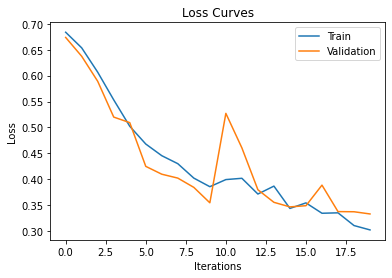

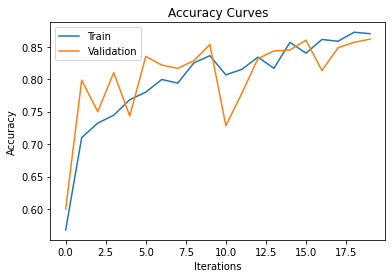

In [0]:
model_ft = models.resnet50(pretrained=True)
for p in model_ft.parameters():
    p.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Get dataloaders
tr, v, te = get_data_loader(32)

model_ft = train_model(model_ft, tr, v, criterion, optimizer_ft, num_epochs=20, overfit=False)

In [0]:
torch.save(model_ft.state_dict(), '/content/drive/My Drive/APS360_Project/SunnyNet/Model/bs{}-lr{}'.format(32, 0.001))

NameError: ignored

[32, 0.01]5
57
Epoch 0/9
----------
TrLoss: 0.5866 TrAcc: 0.6828 | VLoss: 0.3934 VAcc: 0.8350
Epoch 1/9
----------
TrLoss: 0.4673 TrAcc: 0.7594 | VLoss: 0.4379 VAcc: 0.8050
Epoch 2/9
----------
TrLoss: 0.4472 TrAcc: 0.7872 | VLoss: 0.5216 VAcc: 0.7067
Epoch 3/9
----------
TrLoss: 0.4229 TrAcc: 0.7956 | VLoss: 0.5863 VAcc: 0.6850
Epoch 4/9
----------
TrLoss: 0.4347 TrAcc: 0.7939 | VLoss: 0.4086 VAcc: 0.8033
Epoch 5/9
----------
TrLoss: 0.3922 TrAcc: 0.8228 | VLoss: 0.3259 VAcc: 0.8533
Epoch 6/9
----------
TrLoss: 0.3478 TrAcc: 0.8489 | VLoss: 0.3406 VAcc: 0.8350
Epoch 7/9
----------
TrLoss: 0.3617 TrAcc: 0.8361 | VLoss: 0.3543 VAcc: 0.8450
Epoch 8/9
----------
TrLoss: 0.3001 TrAcc: 0.8672 | VLoss: 0.4872 VAcc: 0.7767
Epoch 9/9
----------
TrLoss: 0.3136 TrAcc: 0.8600 | VLoss: 0.3314 VAcc: 0.8550


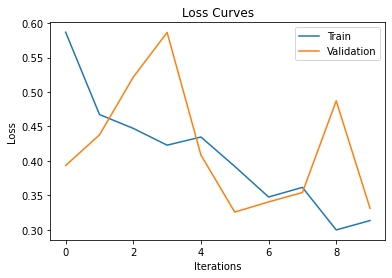

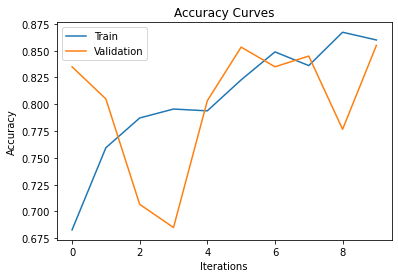

[32, 0.05]6
57
Epoch 0/9
----------
TrLoss: 0.6367 TrAcc: 0.6789 | VLoss: 0.5510 VAcc: 0.7083
Epoch 1/9
----------
TrLoss: 0.6650 TrAcc: 0.6539 | VLoss: 0.7282 VAcc: 0.5000
Epoch 2/9
----------
TrLoss: 0.6075 TrAcc: 0.6517 | VLoss: 0.5323 VAcc: 0.7250
Epoch 3/9
----------
TrLoss: 0.6058 TrAcc: 0.6328 | VLoss: 0.5626 VAcc: 0.6967
Epoch 4/9
----------
TrLoss: 0.6788 TrAcc: 0.5933 | VLoss: 0.6903 VAcc: 0.5350
Epoch 5/9
----------
TrLoss: 0.6913 TrAcc: 0.5300 | VLoss: 0.6932 VAcc: 0.5000
Epoch 6/9
----------
TrLoss: 0.6946 TrAcc: 0.4911 | VLoss: 0.6918 VAcc: 0.5150
Epoch 7/9
----------
TrLoss: 0.6420 TrAcc: 0.6133 | VLoss: 0.7316 VAcc: 0.5317
Epoch 8/9
----------
TrLoss: 0.5646 TrAcc: 0.7172 | VLoss: 0.6337 VAcc: 0.6517
Epoch 9/9
----------
TrLoss: 0.5487 TrAcc: 0.7278 | VLoss: 0.4265 VAcc: 0.8317


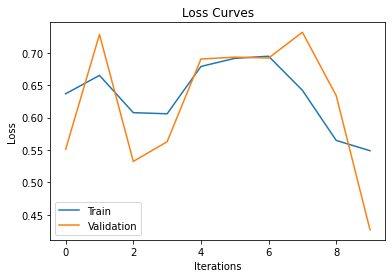

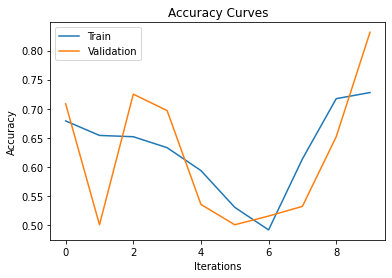

[64, 0.0001]7
29
Epoch 0/9
----------
TrLoss: 0.6932 TrAcc: 0.5022 | VLoss: 0.6940 VAcc: 0.4700
Epoch 1/9
----------
TrLoss: 0.6914 TrAcc: 0.5522 | VLoss: 0.6923 VAcc: 0.5283
Epoch 2/9
----------
TrLoss: 0.6896 TrAcc: 0.5911 | VLoss: 0.6907 VAcc: 0.5600
Epoch 3/9
----------
TrLoss: 0.6877 TrAcc: 0.6194 | VLoss: 0.6890 VAcc: 0.5883
Epoch 4/9
----------
TrLoss: 0.6856 TrAcc: 0.6494 | VLoss: 0.6872 VAcc: 0.6250
Epoch 5/9
----------
TrLoss: 0.6839 TrAcc: 0.6700 | VLoss: 0.6856 VAcc: 0.6550
Epoch 6/9
----------
TrLoss: 0.6820 TrAcc: 0.6911 | VLoss: 0.6836 VAcc: 0.6867
Epoch 7/9
----------
TrLoss: 0.6801 TrAcc: 0.6867 | VLoss: 0.6825 VAcc: 0.6633
Epoch 8/9
----------
TrLoss: 0.6781 TrAcc: 0.6961 | VLoss: 0.6807 VAcc: 0.6800
Epoch 9/9
----------
TrLoss: 0.6761 TrAcc: 0.7056 | VLoss: 0.6791 VAcc: 0.6700


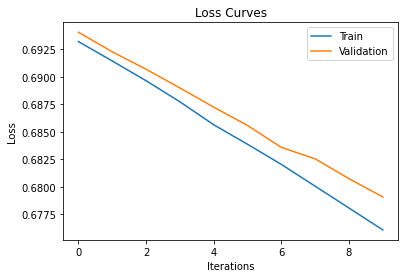

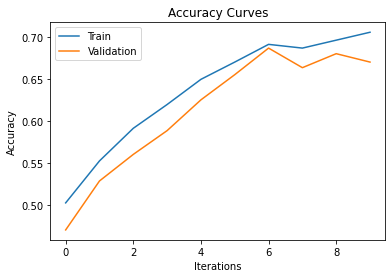

[64, 0.0005]8
29
Epoch 0/9
----------
TrLoss: 0.6932 TrAcc: 0.5100 | VLoss: 0.6873 VAcc: 0.6183
Epoch 1/9
----------
TrLoss: 0.6847 TrAcc: 0.6272 | VLoss: 0.6813 VAcc: 0.6433
Epoch 2/9
----------
TrLoss: 0.6763 TrAcc: 0.6950 | VLoss: 0.6741 VAcc: 0.7100
Epoch 3/9
----------
TrLoss: 0.6670 TrAcc: 0.7383 | VLoss: 0.6654 VAcc: 0.7533
Epoch 4/9
----------
TrLoss: 0.6578 TrAcc: 0.7378 | VLoss: 0.6556 VAcc: 0.7800
Epoch 5/9
----------
TrLoss: 0.6464 TrAcc: 0.7556 | VLoss: 0.6463 VAcc: 0.7717
Epoch 6/9
----------
TrLoss: 0.6336 TrAcc: 0.7589 | VLoss: 0.6339 VAcc: 0.7733
Epoch 7/9
----------
TrLoss: 0.6194 TrAcc: 0.7550 | VLoss: 0.6192 VAcc: 0.8033
Epoch 8/9
----------
TrLoss: 0.6037 TrAcc: 0.7656 | VLoss: 0.6034 VAcc: 0.8083
Epoch 9/9
----------
TrLoss: 0.5894 TrAcc: 0.7594 | VLoss: 0.5862 VAcc: 0.8133


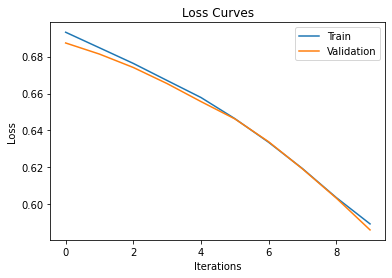

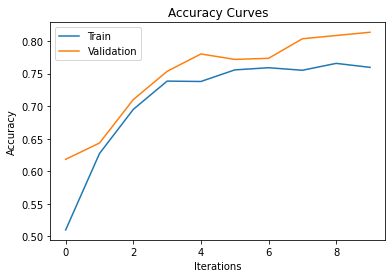

[64, 0.001]9
29
Epoch 0/9
----------
TrLoss: 0.6899 TrAcc: 0.5617 | VLoss: 0.6856 VAcc: 0.6383
Epoch 1/9
----------
TrLoss: 0.6731 TrAcc: 0.6083 | VLoss: 0.6691 VAcc: 0.7317
Epoch 2/9
----------
TrLoss: 0.6517 TrAcc: 0.7528 | VLoss: 0.6489 VAcc: 0.7683
Epoch 3/9
----------
TrLoss: 0.6293 TrAcc: 0.7394 | VLoss: 0.6246 VAcc: 0.7917
Epoch 4/9
----------
TrLoss: 0.6009 TrAcc: 0.7583 | VLoss: 0.5934 VAcc: 0.7933
Epoch 5/9
----------
TrLoss: 0.5652 TrAcc: 0.7767 | VLoss: 0.5571 VAcc: 0.7983
Epoch 6/9
----------
TrLoss: 0.5339 TrAcc: 0.7744 | VLoss: 0.5283 VAcc: 0.8067
Epoch 7/9
----------
TrLoss: 0.5018 TrAcc: 0.7878 | VLoss: 0.4904 VAcc: 0.8150
Epoch 8/9
----------
TrLoss: 0.4783 TrAcc: 0.7894 | VLoss: 0.4632 VAcc: 0.8183
Epoch 9/9
----------
TrLoss: 0.4622 TrAcc: 0.7828 | VLoss: 0.4406 VAcc: 0.8283


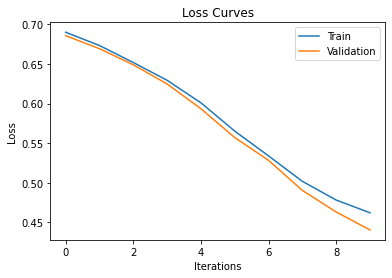

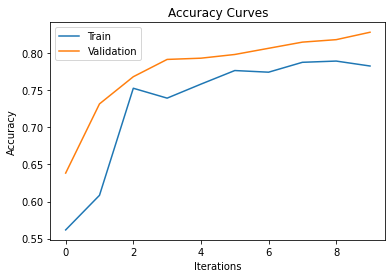

[64, 0.005]10
29
Epoch 0/9
----------
TrLoss: 0.6721 TrAcc: 0.6261 | VLoss: 0.6381 VAcc: 0.7567
Epoch 1/9
----------
TrLoss: 0.5757 TrAcc: 0.7417 | VLoss: 0.5194 VAcc: 0.7567
Epoch 2/9
----------
TrLoss: 0.4698 TrAcc: 0.7728 | VLoss: 0.4211 VAcc: 0.8000
Epoch 3/9
----------
TrLoss: 0.4429 TrAcc: 0.7900 | VLoss: 0.4281 VAcc: 0.7883
Epoch 4/9
----------
TrLoss: 0.5165 TrAcc: 0.7528 | VLoss: 0.4127 VAcc: 0.8150
Epoch 5/9
----------
TrLoss: 0.4024 TrAcc: 0.8200 | VLoss: 0.3609 VAcc: 0.8383
Epoch 6/9
----------
TrLoss: 0.4052 TrAcc: 0.8050 | VLoss: 0.3638 VAcc: 0.8417
Epoch 7/9
----------
TrLoss: 0.3543 TrAcc: 0.8356 | VLoss: 0.4707 VAcc: 0.7800
Epoch 8/9
----------
TrLoss: 0.3738 TrAcc: 0.8244 | VLoss: 0.3402 VAcc: 0.8633
Epoch 9/9
----------
TrLoss: 0.3396 TrAcc: 0.8506 | VLoss: 0.3748 VAcc: 0.8267


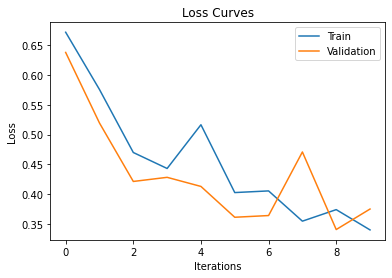

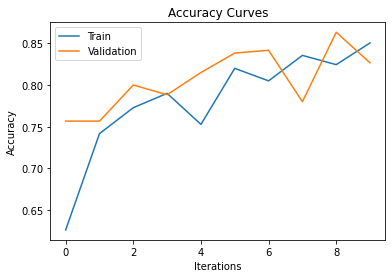

[64, 0.01]11
29
Epoch 0/9
----------
TrLoss: 0.6563 TrAcc: 0.6194 | VLoss: 0.5928 VAcc: 0.6433
Epoch 1/9
----------
TrLoss: 0.5226 TrAcc: 0.7350 | VLoss: 0.6814 VAcc: 0.6500
Epoch 2/9
----------
TrLoss: 0.4974 TrAcc: 0.7600 | VLoss: 0.4218 VAcc: 0.8017
Epoch 3/9
----------
TrLoss: 0.3873 TrAcc: 0.8244 | VLoss: 0.4102 VAcc: 0.8000
Epoch 4/9
----------
TrLoss: 0.3725 TrAcc: 0.8367 | VLoss: 0.3441 VAcc: 0.8483
Epoch 5/9
----------


In [0]:
model_ft = models.resnet50(pretrained=True)
for p in model_ft.parameters():
    p.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)

batch_size = [32, 64, 128, 256]
# print(batch_size)

lr = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2])
# print(lr)
criterion = nn.CrossEntropyLoss()
c = 0
grid = product(batch_size, lr)
for combo in grid:
  if c < 4:
    c+=1
    continue
  model_ft = models.resnet50(pretrained=True)
  for p in model_ft.parameters():
      p.requires_grad = False
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Sequential(
      nn.Linear(num_ftrs, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 2)
  )
  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=combo[1], momentum=0.9)
  # Get dataloaders
  tr, v, te = get_data_loader(combo[0])
  c += 1
  print(str([combo[0], combo[1]]) + str(c))
  model_ft = train_model(model_ft, tr, v, criterion, optimizer_ft, num_epochs=10, overfit=False)
  torch.save(model_ft.state_dict(), '/content/drive/My Drive/APS360_Project/SunnyNet/Model/bs{}-lr{}'.format(combo[0], combo[1]))

In [0]:
finalmodel = models.resnet50(pretrained=True)
for p in finalmodel.parameters():
    p.requires_grad = False
num_ftrs = finalmodel.fc.in_features
finalmodel.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)
finalmodel.load_state_dict(torch.load('/content/drive/My Drive/APS360_Project/SunnyNet/Model/FinalModel/bs32-lr0.001'))
tr, v, te = get_data_loader(32)
criterion = nn.CrossEntropyLoss()
print(evaluate(finalmodel, te, criterion))

(0.2549171866973241, tensor(0.8967, dtype=torch.float64))


In [0]:
test_negative_indices = np.arange(1200,1500)
test_positive_indices = np.arange(2700, 3000)
test_negative_dataset = torch.utils.data.Subset(dataset, test_negative_indices)
test_positive_dataset = torch.utils.data.Subset(dataset, test_positive_indices)
te_n = torch.utils.data.dataloader.DataLoader(test_negative_dataset, batch_size=1, shuffle=True)
te_p = torch.utils.data.dataloader.DataLoader(test_positive_dataset, batch_size=1, shuffle=True)
te_n_l, te_n_a = evaluate(finalmodel, te_n, criterion)
te_p_l, te_p_a = evaluate(finalmodel, te_p, criterion)
print('False negatives: ' + str(1-te_n_a.item()))
print('False positives: ' + str(1-te_p_a.item()))

False negatives: 0.08666666666666667
False positives: 0.12
